#  Proyecto 3 Machine Learning: Clasificación de Emociones en Texto
## Algoritmos de Machine Learning y Redes Neuronales (Naive Bayes vs. Perceptrón Multicapa)


#  Descarga y preparación del dataset

En esta sección descargamos el dataset de emociones desde Kaggle, configuramos las credenciales de acceso y descomprimimos los archivos para poder utilizarlos en el proyecto.


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andresrami103","key":"621144bda863f04d8e8cda558b7cefe9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d parulpandey/emotion-dataset


Dataset URL: https://www.kaggle.com/datasets/parulpandey/emotion-dataset
License(s): CC0-1.0
emotion-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q emotion-dataset.zip


# 📂 Carga de datos

En esta sección cargamos los archivos CSV de entrenamiento, validación y prueba, y hacemos una vista rápida de las primeras filas para entender la estructura del dataset.


In [ ]:
import pandas as pd

train = pd.read_csv("training.csv")
val = pd.read_csv("validation.csv")
test = pd.read_csv("test.csv")

train.head()


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


# 📊 Distribución de etiquetas

Aquí exploramos cuántos ejemplos hay de cada emoción en el conjunto de entrenamiento. Esto nos ayuda a identificar si el dataset está balanceado o si algunas clases son minoritarias.


In [ ]:
train.label.value_counts()


,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


# ✨ Preprocesamiento del texto

En esta sección limpiamos el texto de los datasets eliminando URLs, símbolos y espacios extra, y pasamos todo a minúsculas. Esto ayuda a mejorar la calidad de los datos para el modelo.


In [ ]:
import re

def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+|www\S+", "", t)      # quitar URLs
    t = re.sub(r"[^a-zA-Z\s]", "", t)        # quitar símbolos
    t = re.sub(r"\s+", " ", t).strip()       # espacios dobles
    return t

train["clean_text"] = train["text"].apply(clean_text)
val["clean_text"] = val["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)


# 📝 Vectorización del texto

Aquí convertimos el texto en representaciones numéricas usando TF-IDF, considerando un máximo de 10,000 características y combinando unigrams y bigrams.  
Esto permite que los modelos de machine learning puedan procesar los datos textuales.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train = vectorizer.fit_transform(train["clean_text"])
X_val = vectorizer.transform(val["clean_text"])
X_test = vectorizer.transform(test["clean_text"])

y_train = train["label"]
y_val = val["label"]
y_test = test["label"]


# 🧠 Entrenamiento y evaluación - Naive Bayes

En esta sección entrenamos un clasificador Naive Bayes multinomial sobre los datos de entrenamiento y evaluamos su desempeño en el conjunto de validación.  
También definimos una función para predecir la emoción de textos individuales y visualizamos los resultados mediante gráficas, incluyendo la matriz de confusión y la distribución de aciertos por clase.


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

nb = MultinomialNB()
nb.fit(X_train, y_train)


MultinomialNB()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

preds = nb.predict(X_val)
accuracy_naive_bayes=accuracy_score(y_val, preds)
print("Accuracy:", accuracy_score(y_val, preds))
print("\nClassification Report:\n")
print(classification_report(y_val, preds))


Accuracy: 0.776

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       550
           1       0.73      0.98      0.84       704
           2       0.97      0.20      0.33       178
           3       0.96      0.61      0.75       275
           4       0.91      0.58      0.71       212
           5       1.00      0.12      0.22        81

    accuracy                           0.78      2000
   macro avg       0.89      0.58      0.62      2000
weighted avg       0.82      0.78      0.74      2000



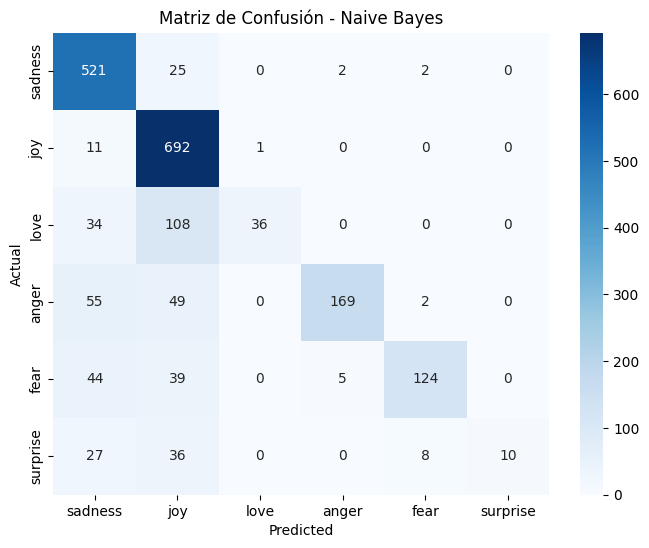

In [ ]:
cm = confusion_matrix(y_val, preds)
labels = ["sadness","joy","love","anger","fear","surprise"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión - Naive Bayes")
plt.show()

/tmp/ipython-input-234244946.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=recall_values, palette="pastel")


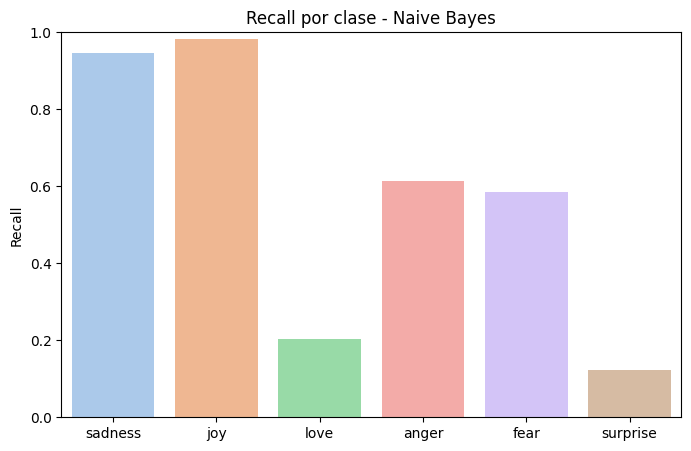

In [ ]:
recalls = classification_report(y_val, preds, output_dict=True)
recall_values = [recalls[label]["recall"] for label in ["0","1","2","3","4","5"]]

plt.figure(figsize=(8,5))
sns.barplot(x=labels, y=recall_values, palette="pastel")
plt.ylabel("Recall")
plt.title("Recall por clase - Naive Bayes")
plt.ylim(0,1)
plt.show()

# Función para predecir emociones de textos individuales

In [ ]:
def predict_emotion(text):
    cleaned = clean_text(text)

    X = vectorizer.transform([cleaned])

    label = nb.predict(X)[0]

    emotion_map = {
        0: "sadness",
        1: "joy",
        2: "love",
        3: "anger",
        4: "fear",
        5: "surprise"
    }

    return emotion_map[label]


In [ ]:
predict_emotion("i love you")


'joy'

# ⚙️ Instalación de librerías adicionales

En esta sección instalamos `imbalanced-learn`, que nos permitirá aplicar técnicas de oversampling para balancear las clases minoritarias del dataset.


In [ ]:
!pip install imbalanced-learn


# 🔄 Balanceo de clases con Oversampling

Aquí aplicamos **RandomOverSampler** para aumentar artificialmente la cantidad de ejemplos en las clases minoritarias, igualando el número de muestras de cada emoción.  
Esto permite que el modelo no ignore emociones poco frecuentes como *love* o *surprise*.


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)


X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Tamaño original:", X_train.shape, "→ tamaño balanceado:", X_train_resampled.shape)


Tamaño original: (16000, 10000) → tamaño balanceado: (32172, 10000)


# 📊 Distribución de etiquetas después del oversampling

Mostramos la cantidad de ejemplos por clase tras aplicar oversampling para verificar que todas las emociones tienen la misma cantidad de datos.


In [ ]:
pd.Series(y_train_resampled).value_counts()

,count
label,
0,5362
3,5362
2,5362
5,5362
4,5362
1,5362


# 🧠 Entrenamiento y evaluación - Naive Bayes con oversampling

Entrenamos un clasificador Naive Bayes multinomial sobre los datos balanceados.  
Evaluamos el desempeño en el conjunto de prueba y mostramos métricas como **accuracy**, **precision**, **recall** y **f1-score** para cada emoción.


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

model = MultinomialNB()
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
accuracy_nb_ros=accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.857
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       581
           1       0.94      0.84      0.89       695
           2       0.64      0.88      0.74       159
           3       0.81      0.87      0.84       275
           4       0.85      0.82      0.83       224
           5       0.55      0.91      0.69        66

    accuracy                           0.86      2000
   macro avg       0.79      0.87      0.82      2000
weighted avg       0.88      0.86      0.86      2000



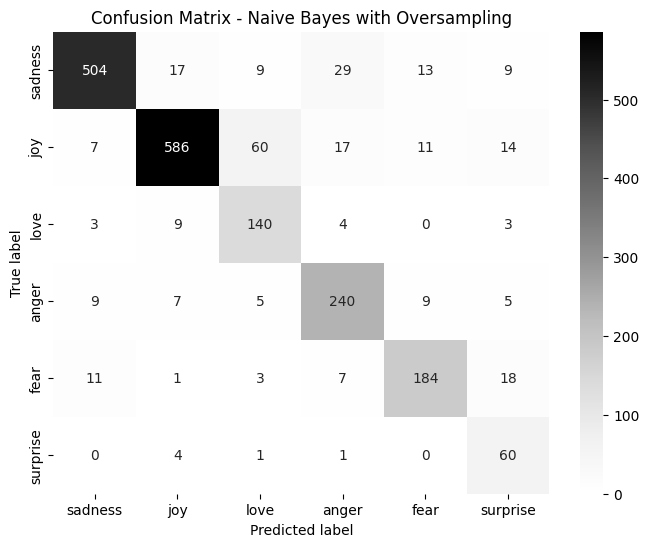

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# calcular matriz
cm = confusion_matrix(y_test, y_pred)

# etiquetas de emociones
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greys",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Naive Bayes with Oversampling")
plt.show()


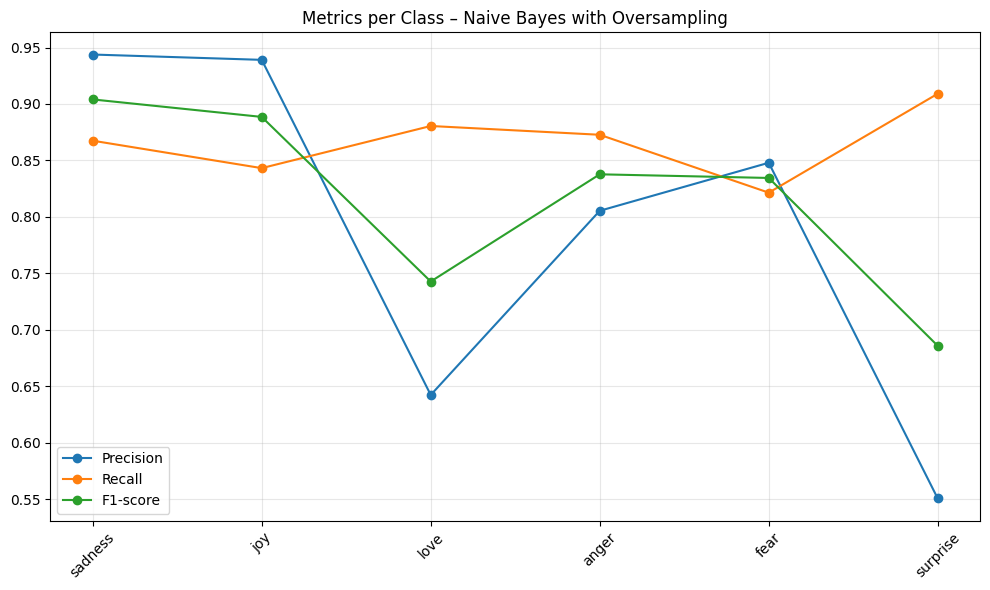

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)

x = np.arange(len(labels))

plt.figure(figsize=(10,6))
plt.plot(x, precision, marker="o", label="Precision")
plt.plot(x, recall, marker="o", label="Recall")
plt.plot(x, f1, marker="o", label="F1-score")

plt.xticks(x, labels, rotation=45)
plt.title("Metrics per Class – Naive Bayes with Oversampling")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# 💬 Función de predicción personalizada

Definimos `predict_emotion2` para predecir la emoción de cualquier texto nuevo usando el modelo entrenado con oversampling.  
Esto permite probar rápidamente frases y ver cómo clasifica el modelo cada emoción.


In [ ]:
def predict_emotion2(text):

    vec = vectorizer.transform([text])

    pred_label = model.predict(vec)[0]


    emotion_map = {
        0: "sadness",
        1: "joy",
        2: "love",
        3: "anger",
        4: "fear",
        5: "surprise"
    }

    return emotion_map[pred_label]


In [ ]:
predict_emotion2("i love you")



'love'

# 🧠 Entrenamiento del MLP (sin balancear)

En esta sección entrenamos un Perceptrón Multicapa (MLP) usando los datos originales, los cuales están desbalanceados.  
Este modelo nos servirá como línea base para compararlo contra la versión entrenada después del oversampling (ROS).

Se generan:

- Entrenamiento del MLP con los textos vectorizados (TF-IDF)  
- Evaluación usando el conjunto de prueba original  
- Reporte completo por clase (precision, recall y f1-score)  
- Esta versión del modelo muestra cómo afecta el desbalance de clases al rendimiento del MLP  


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

print("--- Entrenando Perceptrón Multicapa (MLP) en Datos ORIGINALES (Sin ROS) ---")
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
labels = list(emotion_map.values())
mlp_original = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=150,
    tol=1e-3,
    random_state=42,
    verbose=True
)


mlp_original.fit(X_train, y_train)


y_pred_mlp_original = mlp_original.predict(X_test)

accuracy_mlp_original = accuracy_score(y_test, y_pred_mlp_original)

print("\n--- Resultados del Perceptrón Multicapa (MLP) - SIN ROS ---")
print(f"Accuracy en Test Set: {accuracy_mlp_original:.4f}")

print(classification_report(y_test, y_pred_mlp_original, target_names=labels))

--- Entrenando Perceptrón Multicapa (MLP) en Datos ORIGINALES (Sin ROS) ---
Iteration 1, loss = 1.53846306
Iteration 2, loss = 0.95636822
Iteration 3, loss = 0.48450810
Iteration 4, loss = 0.26486473
Iteration 5, loss = 0.16701071
Iteration 6, loss = 0.11636486
Iteration 7, loss = 0.08682974
Iteration 8, loss = 0.06782425
Iteration 9, loss = 0.05486574
Iteration 10, loss = 0.04567794
Iteration 11, loss = 0.03888202
Iteration 12, loss = 0.03372980
Iteration 13, loss = 0.02964064
Iteration 14, loss = 0.02655628
Iteration 15, loss = 0.02386280
Iteration 16, loss = 0.02199958
Iteration 17, loss = 0.02030010
Iteration 18, loss = 0.01880423
Iteration 19, loss = 0.01754452
Iteration 20, loss = 0.01640452
Iteration 21, loss = 0.01572808
Iteration 22, loss = 0.01489161
Iteration 23, loss = 0.01417356
Iteration 24, loss = 0.01375998
Iteration 25, loss = 0.01318470
Iteration 26, loss = 0.01249541
Iteration 27, loss = 0.01236762
Iteration 28, loss = 0.01201445
Iteration 29, loss = 0.01170431
Itera

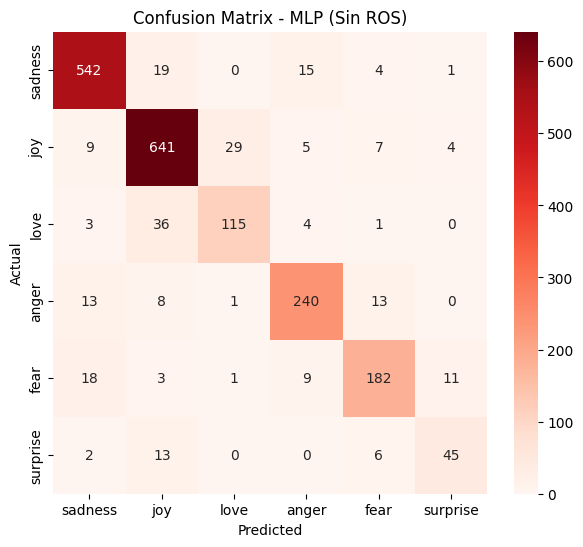

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_original = confusion_matrix(y_test, y_pred_mlp_original)

plt.figure(figsize=(7,6))
sns.heatmap(cm_original, annot=True, fmt="d", cmap="Reds",
            xticklabels=emotion_map.values(),
            yticklabels=emotion_map.values())
plt.title("Confusion Matrix - MLP (Sin ROS)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


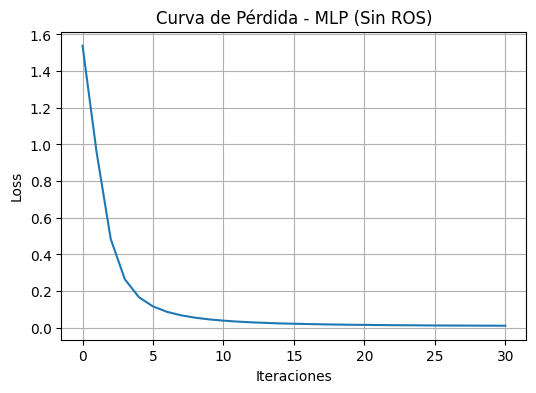

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(mlp_original.loss_curve_)
plt.title("Curva de Pérdida - MLP (Sin ROS)")
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### 🔍 Función de predicción para el MLP
Aquí se define una función que permite ingresar cualquier frase y obtener la emoción predicha por el modelo entrenado.


In [ ]:
def predict_emotion_mlp_original(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred_label = mlp_original.predict(vec)[0]

    emotion_map = {
        0: 'sadness',
        1: 'joy',
        2: 'love',
        3: 'anger',
        4: 'fear',
        5: 'surprise'
    }
    return emotion_map[pred_label]

# Ejemplo:
predict_emotion_mlp_original("Life is good")


'joy'

# 🧠🔄 Entrenamiento del MLP con Oversampling (ROS)

Aquí entrenamos un segundo Perceptrón Multicapa (MLP), pero esta vez usando los datos balanceados mediante **Random OverSampling (ROS)**.  
Esto nos permitirá comparar directamente si el balanceo mejora el desempeño del modelo en clases minoritarias como *love* y *surprise*.

En esta sección se realiza:

- Entrenamiento del MLP con los datos aumentados por oversampling  
- Predicción sobre el mismo conjunto de prueba  
- Reporte detallado por clase para comparar con el modelo sin ROS  
- Análisis de si el balanceo afecta el desempeño general  


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

print("--- Entrenando Perceptrón Multicapa (MLP) con ROS Data ---")

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=150,
    tol=1e-3,
    random_state=42,
    verbose=True
)

mlp_model.fit(X_train_resampled, y_train_resampled)

y_pred_mlp = mlp_model.predict(X_test)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

print("\n--- Resultados del Perceptrón Multicapa (MLP) ---")
print(f"Accuracy en Test Set: {accuracy_mlp:.4f}")

print(classification_report(y_test, y_pred_mlp, target_names=emotion_map.values()))


--- Entrenando Perceptrón Multicapa (MLP) con ROS Data ---
Iteration 1, loss = 1.26920660
Iteration 2, loss = 0.31795598
Iteration 3, loss = 0.12685953
Iteration 4, loss = 0.07389671
Iteration 5, loss = 0.04993122
Iteration 6, loss = 0.03701276
Iteration 7, loss = 0.02911355
Iteration 8, loss = 0.02411459
Iteration 9, loss = 0.02068800
Iteration 10, loss = 0.01809032
Iteration 11, loss = 0.01635425
Iteration 12, loss = 0.01512620
Iteration 13, loss = 0.01401478
Iteration 14, loss = 0.01330347
Iteration 15, loss = 0.01270616
Iteration 16, loss = 0.01210772
Iteration 17, loss = 0.01163154
Iteration 18, loss = 0.01120037
Iteration 19, loss = 0.01086855
Iteration 20, loss = 0.01080323
Iteration 21, loss = 0.01058126
Iteration 22, loss = 0.01036087
Iteration 23, loss = 0.01033629
Iteration 24, loss = 0.01002083
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

--- Resultados del Perceptrón Multicapa (MLP) ---
Accuracy en Test Set: 0.8735
            

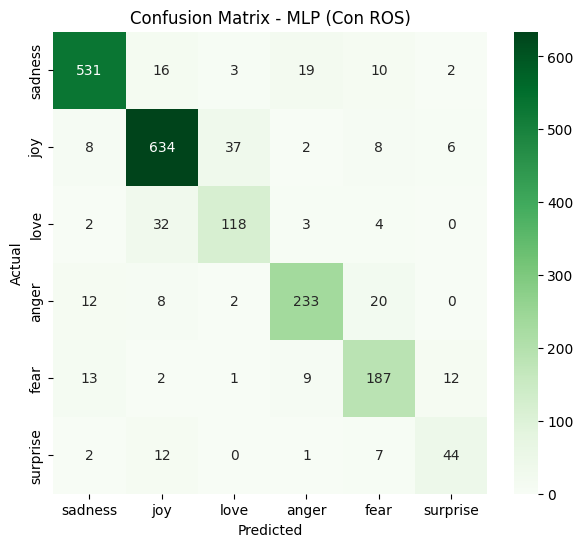

In [ ]:
cm_ros = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(7,6))
sns.heatmap(cm_ros, annot=True, fmt="d", cmap="Greens",
            xticklabels=emotion_map.values(),
            yticklabels=emotion_map.values())
plt.title("Confusion Matrix - MLP (Con ROS)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


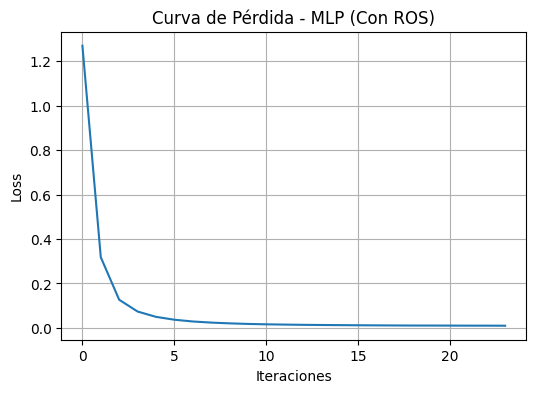

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(mlp_model.loss_curve_)
plt.title("Curva de Pérdida - MLP (Con ROS)")
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### 🔍 Función de predicción para el MLP
Aquí se define una función que permite ingresar cualquier frase y obtener la emoción predicha por el modelo entrenado.


In [ ]:
def predict_emotion_mlp_ros(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred_label = mlp_model.predict(vec)[0]

    emotion_map = {
        0: 'sadness',
        1: 'joy',
        2: 'love',
        3: 'anger',
        4: 'fear',
        5: 'surprise'
    }
    return emotion_map[pred_label]

# Ejemplo:
predict_emotion_mlp_ros("I am feeling good today")


'joy'

#Graficas de comparacion entre ambos modelos


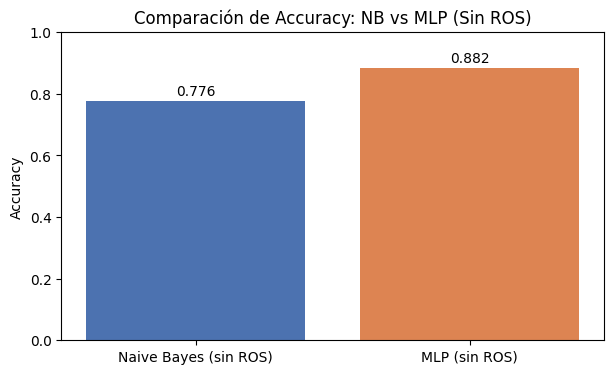

In [ ]:
import matplotlib.pyplot as plt



accuracies = [accuracy_naive_bayes, accuracy_mlp_original]
labels_bar = ["Naive Bayes (sin ROS)", "MLP (sin ROS)"]
colors = ["#4C72B0", "#DD8452"]
plt.figure(figsize=(7,4))
bars1 = plt.bar(labels_bar, accuracies, color=colors)
plt.bar(labels_bar, accuracies,color=colors)
for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.3f}",
        ha='center', va='bottom'
    )


plt.ylim(0,1)
plt.title("Comparación de Accuracy: NB vs MLP (Sin ROS)")
plt.ylabel("Accuracy")
plt.show()


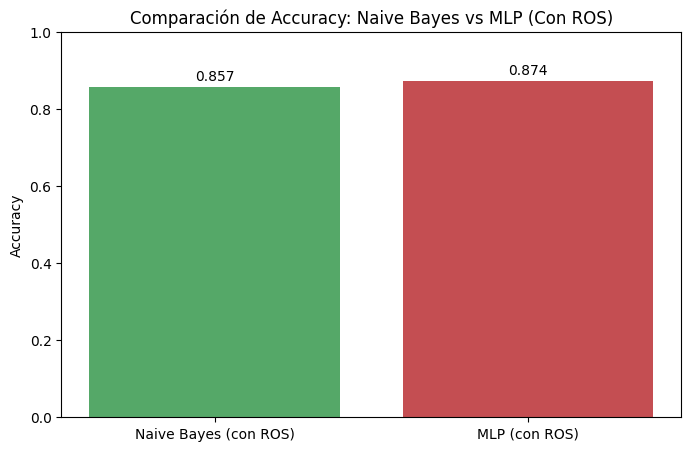

In [ ]:

accuracies_ros = [accuracy_nb_ros, accuracy_mlp]
labels_bar_ros = ["Naive Bayes (con ROS)", "MLP (con ROS)"]
colors_ros = ["#55A868", "#C44E52"]  # verde y rojo elegante
plt.figure(figsize=(8,5))
bars = plt.bar(labels_bar_ros, accuracies_ros, color=colors_ros)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.3f}",
        ha='center', va='bottom'
    )

plt.ylim(0,1)
plt.title("Comparación de Accuracy: Naive Bayes vs MLP (Con ROS)")
plt.ylabel("Accuracy")
plt.show()
